In [1]:
import pandas as pd
import os
import re
import openpyxl

In [2]:
print(os.getcwd())

/home/notvisal/Desktop/Intern/Knife_Sharpness_Dataset


In [3]:
P1_contents = os.listdir('Theme2/P1/Boning/')

print(P1_contents)

['MVN-J-Boning-64-001.xlsx', 'MVN-J-Boning-90-003.xlsx', 'MVN-J-Boning-90-002.xlsx', 'MVN-J-Boning-90-004.xlsx', 'MVN-J-Boning-64-006.xlsx', 'MVN-J-Boning-64-004.xlsx', 'MVN-J-Boning-64-002.xlsx', 'MVN-J-Boning-90-001.xlsx', 'MVN-J-Boning-64-003.xlsx', 'MVN-J-Boning-79-001.xlsx', 'MVN-J-Boning-64-005.xlsx']


In [4]:
P1_BONING_PATHS = [
    'Theme2/P1/Boning/MVN-J-Boning-64-001.xlsx', 
    'Theme2/P1/Boning/MVN-J-Boning-90-003.xlsx', 
    'Theme2/P1/Boning/MVN-J-Boning-90-002.xlsx', 
    'Theme2/P1/Boning/MVN-J-Boning-90-004.xlsx', 
    'Theme2/P1/Boning/MVN-J-Boning-64-006.xlsx', 
    'Theme2/P1/Boning/MVN-J-Boning-64-004.xlsx', 
    'Theme2/P1/Boning/MVN-J-Boning-64-002.xlsx', 
    'Theme2/P1/Boning/MVN-J-Boning-90-001.xlsx', 
    'Theme2/P1/Boning/MVN-J-Boning-64-003.xlsx', 
    'Theme2/P1/Boning/MVN-J-Boning-79-001.xlsx', 
    'Theme2/P1/Boning/MVN-J-Boning-64-005.xlsx'
]

ACCELERATION_SHEETS = [
    'Segment Acceleration', 
    'Segment Angular Acceleration'
]

ACTIVITY_LABELS = {
    0: 'Idle',
    1: 'Walking', 
    2: 'Steeling',
    3: 'Reaching',
    4: 'Cutting',
    5: 'Dropping'
}

In [5]:
xls_file = pd.ExcelFile(P1_BONING_PATHS[1])

print(xls_file.sheet_names)

df = xls_file.parse('Markers')
df.head(10)

['General Information', 'Markers', 'Segment Orientation - Quat', 'Segment Orientation - Euler', 'Segment Position', 'Segment Velocity', 'Segment Acceleration', 'Segment Angular Velocity', 'Segment Angular Acceleration', 'Joint Angles ZXY', 'Joint Angles XZY', 'Ergonomic Joint Angles ZXY', 'Ergonomic Joint Angles XZY', 'Center of Mass', 'Sensor Free Acceleration', 'Sensor Magnetic Field', 'Sensor Orientation - Quat', 'Sensor Orientation - Euler']


,Frame,Labelling,Unnamed: 2,Unnamed: 3
0,0- 252,0- Idle,Idle,0.0
1,253-417,3- Reaching,Walking,1.0
2,418-1849,4 - Cutting,Steeling,2.0
3,1851-1923,4 - Cutting (offloading bone from Carcass),Reaching,3.0
4,1924-2061,5- Dropping,Cutting,4.0
5,2062-2373,1- Walking,Dropping,5.0
6,2374-2764,2- Steeling,NaN,NaN
7,2765-2875,3- Reaching,NaN,NaN
8,2876-4153,4 - Cutting,NaN,NaN
9,4154-4231,4 - Cutting (offloading bone from Carcass),NaN,NaN


In [6]:
len(df.columns.tolist())

4

In [7]:
# for file in P1_BONING_PATHS:
#     xl = pd.ExcelFile(file)
#     for sheet in ACCELERATION_SHEETS:
#         df = xl.parse(sheet)
#         col = df.columns.tolist()

#         if 'Label' in col:
#             # print(f"{file} {sheet} have label col")
#             continue
#         else:
#             print(f"{file} {sheet} missing label column")
        
#         # print(f"{file}, {sheet}: {df['Label'].isna()}")
    

In [8]:
xl = pd.ExcelFile(P1_BONING_PATHS[1])
df = xl.parse(ACCELERATION_SHEETS[1])

df.head()

,Frame,Label,Pelvis x,Pelvis y,Pelvis z,L5 x,L5 y,L5 z,L3 x,L3 y,...,Left Upper Leg z,Left Lower Leg x,Left Lower Leg y,Left Lower Leg z,Left Foot x,Left Foot y,Left Foot z,Left Toe x,Left Toe y,Left Toe z
0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,0,-1.128749,0.648902,-2.487596,-0.831204,-0.143373,-1.906267,-0.698962,-0.495496,...,-11.281005,0.396790,0.666104,-5.092240,-1.042992,0.438947,-0.256636,-1.042992,0.438947,-0.256636
2,2,0,-0.851040,-0.271079,-1.995743,1.088875,-3.353729,0.853952,1.951060,-4.723795,...,-8.101156,1.039803,1.298700,-2.361782,0.458836,0.217325,-0.207346,0.458836,0.217325,-0.207346
3,3,0,-0.588176,-0.134299,-1.295867,0.000000,0.000000,0.000000,0.000000,0.000000,...,-7.141263,0.552980,1.877903,-3.138768,0.248751,0.682828,0.745742,0.000000,0.000000,0.000000
4,4,0,-0.388814,-2.045831,0.103972,-0.715251,-1.160902,-2.188929,-0.860335,-0.767600,...,-8.961113,1.923597,1.152811,0.873384,-0.760524,-0.201851,0.395706,-0.760525,-0.201851,0.395706


In [9]:
# removing the boning 90 003's segment acceleration sheet, since it's missing a column
# or. inject the segment angular acceleration's label column into the segment acceleration sheet


# **Merging**

In [10]:
# from collections import defaultdict

# sharpness_levels = [64, 79, 90]

# def process_acceleration_data(file_paths, sharpness_levels):
#     """Process acceleration data from multiple Excel files with different sharpness levels."""
#     # Dictionary to store processed data by sheet type
#     sheet_data = defaultdict(list)
    
#     # Process all files and extract data by sheet type
#     for file_path, sharpness in zip(file_paths, sharpness_levels):
#         try:
#             xls = pd.ExcelFile(file_path)
            
#             for sheet_name in xls.sheet_names:
#                 if sheet_name not in ACCELERATION_SHEETS:
#                     continue
                
#                 try:
#                     # Read the sheet
#                     df = pd.read_excel(xls, sheet_name=sheet_name)
#                     print(f"{df.shape}")
                    
#                     if df.empty:
#                         continue

#                     if 'Label' not in df.columns:
#                         print(f"Skipping {sheet_name} since it doesn't have a label column")
#                         continue
                    
#                     # Add sharpness column
#                     df['sharpness'] = sharpness
                    
#                     # Add sheet name as a column to differentiate data source
#                     df['sheet_type'] = sheet_name
                    
#                     # Add to our collection
#                     sheet_data[sheet_name].append(df)
                
#                 except Exception as e:
#                     print(f"Error processing sheet {file_path} {sheet_name}: {e}")
        
#         except Exception as e:
#             print(f"Error processing file {file_path}: {e}")
    
#     # Combine data from all files
#     combined_dfs = []
    
#     for sheet_name, dfs in sheet_data.items():
#         if dfs:
#             # Concatenate all data for this sheet type
#             sheet_combined_df = pd.concat(dfs, ignore_index=True)
#             combined_dfs.append(sheet_combined_df)
    
#     # Return combined data frame
#     if combined_dfs:
#         final_df = pd.concat(combined_dfs, ignore_index=True)
#         return final_df
    
#     return None

# def main():
#     # Process the data
#     merged_df = process_acceleration_data(
#         file_paths=P1_BONING_PATHS,
#         sharpness_levels=sharpness_levels
#     )
    
#     if merged_df is None or merged_df.empty:
#         print("No results generated!")
#         return
    
#     # Save the final merged dataframe
#     output_file = "acceleration_data.csv"
#     merged_df.to_csv(output_file, index=False)
#     print(f"Saved data to {output_file} ({merged_df.shape[0]} rows, {merged_df.shape[1]} columns)")

# if __name__ == "__main__":
#     main()

In [11]:
df = pd.read_csv('acceleration_data.csv')

df.head()

,Frame,Label,Pelvis x,Pelvis y,Pelvis z,L5 x,L5 y,L5 z,L3 x,L3 y,...,Left Lower Leg y,Left Lower Leg z,Left Foot x,Left Foot y,Left Foot z,Left Toe x,Left Toe y,Left Toe z,sharpness,sheet_type
0,0,4,0.0,0.0,0.0,-1.640562,-0.345798,-0.666146,-2.369700,-0.499486,...,-2.060481,-1.485525,-2.185359,-1.194785,-1.663235,-2.185359,-1.194785,-1.663235,64,Segment Acceleration
1,1,4,0.0,0.0,0.0,-0.705326,-0.629461,-0.983502,-1.043948,-0.907626,...,-2.689504,-1.314239,-1.060466,-1.162565,-1.845591,-1.064713,-1.147108,-1.845636,64,Segment Acceleration
2,2,4,0.0,0.0,0.0,-1.146854,-0.839369,-0.862127,-1.683033,-1.219342,...,-2.178955,-1.321744,-0.220440,-1.530509,-1.658241,-0.227187,-1.514522,-1.657987,64,Segment Acceleration
3,3,4,0.0,0.0,0.0,-0.065640,-0.431009,-0.488192,-0.426137,-0.574987,...,-0.951495,-1.324380,-0.175790,-1.007643,-1.326566,-0.091278,-0.986575,-1.316862,64,Segment Acceleration
4,4,4,0.0,0.0,0.0,0.652927,-0.046127,0.174043,0.920047,-0.080622,...,-0.402592,-0.509365,0.347853,-0.509991,-0.538392,0.335083,-0.493518,-0.537629,64,Segment Acceleration


In [12]:
df.shape

(67354, 73)

# **Balance Data and Oversampling**

# **Visualization**

In [13]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set the style for plotting
sns.set(style="whitegrid")

# Define the activity label mapping
ACTIVITY_LABELS = {
    0: 'Idle',
    1: 'Walking', 
    2: 'Steeling',
    3: 'Reaching',
    4: 'Cutting',
    5: 'Dropping'
}

def downsample_data(df, column_name, downsample_factor=10):
    """
    Downsample data to reduce density in visualization
    
    Parameters:
    - df: DataFrame to downsample
    - column_name: Column to use for grouping (usually the time or index column)
    - downsample_factor: Number of samples to combine into one
    
    Returns:
    - Downsampled DataFrame
    """
    # Create a group identifier
    df['group'] = np.floor(np.arange(len(df)) / downsample_factor).astype(int)
    
    # Group by the identifier and calculate means
    # Also keep the activity code and sharpness values (use mode/most common value)
    grouped = df.groupby(['group', 'sharpness', 'activity_code']).agg({
        value_column: 'mean',
        'Label': 'first'  # Keep the original label
    }).reset_index()
    
    return grouped

def create_facet_plots(df, time_column=None, value_column='Right Hand x', downsample_factor=None):
    """
    Create faceted plots separated by sharpness to improve readability.
    
    Parameters:
    - df: The merged DataFrame containing the acceleration data
    - time_column: The column name containing time/sequence information (optional)
    - value_column: The column containing the acceleration values to plot
    - downsample_factor: Factor by which to downsample data (e.g., 10 means take every 10th point)
    """
    # Make a copy of the dataframe to avoid modifying the original
    plot_df = df.copy()
    
    # Get activity label codes
    try:
        # Try to extract activity codes from 'Label'
        plot_df['activity_code'] = plot_df['Label'].apply(lambda x: float(str(x).split('.')[-1]) 
                                           if isinstance(x, str) and '.' in str(x) 
                                           else int(float(x)) if str(x).replace('.', '').isdigit() 
                                           else x)
    except KeyError:
        # If 'Label' doesn't exist, create a placeholder
        print("Warning: 'Label' column not found. Please verify your column names.")
        plot_df['activity_code'] = 0  # Default to the first activity
    
    # Map numerical codes to activity names
    plot_df['activity_name'] = plot_df['activity_code'].map(lambda x: ACTIVITY_LABELS.get(int(x), f"Activity {x}"))
    
    # Get unique sharpness levels
    sharpness_levels = sorted(plot_df['sharpness'].unique())
    
    # Create a figure with a subplot for each sharpness level
    fig, axes = plt.subplots(len(sharpness_levels), 1, figsize=(15, 5*len(sharpness_levels)), sharex=True)
    
    # If there's only one sharpness level, axes won't be an array
    if len(sharpness_levels) == 1:
        axes = [axes]
    
    # Create a color palette for activity labels
    activity_names = list(ACTIVITY_LABELS.values())
    activity_palette = sns.color_palette("Set1", len(activity_names))
    activity_colors = {name: color for name, color in zip(activity_names, activity_palette)}
    
    # Plot each sharpness level in its own subplot
    for i, sharpness in enumerate(sharpness_levels):
        ax = axes[i]
        sharpness_data = plot_df[plot_df['sharpness'] == sharpness]
        
        for activity_code, activity_name in ACTIVITY_LABELS.items():
            label_data = sharpness_data[sharpness_data['activity_code'] == activity_code]
            
            if not label_data.empty:
                # If downsampling is requested
                if downsample_factor and downsample_factor > 1:
                    # Downsample by taking every Nth point
                    label_data = label_data.iloc[::downsample_factor].copy()
                
                # If no time column is provided, use the index or create a sequence
                if time_column is None or time_column not in label_data.columns:
                    x_values = np.arange(len(label_data))
                else:
                    # Sort by time column
                    label_data = label_data.sort_values(by=time_column)
                    x_values = label_data[time_column]
                
                # Plot the data
                ax.plot(
                    x_values,
                    label_data[value_column],
                    label=activity_name,
                    color=activity_colors[activity_name],
                    linewidth=2,
                    alpha=0.8
                )
        
        # Set titles and labels
        ax.set_title(f'Sharpness Level: {sharpness}', fontsize=14)
        ax.set_ylabel(value_column, fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.legend(loc='upper right')
    
    # Set the bottom x-axis label
    if time_column and time_column in plot_df.columns:
        axes[-1].set_xlabel(time_column, fontsize=12)
    else:
        axes[-1].set_xlabel('Sample Index', fontsize=12)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

def visualize_combined_sharpness(df, time_column=None, value_column='Right Hand x', downsample_factor=None):
    """
    Create a single graph with all sharpness levels and activities together.
    
    Parameters:
    - df: The merged DataFrame containing the acceleration data
    - time_column: The column name containing time/sequence information (optional)
    - value_column: The column containing the acceleration values to plot
    - downsample_factor: Factor by which to downsample data (e.g., 10 means take every 10th point)
    """
    # Create a figure
    plt.figure(figsize=(15, 10))
    
    # Make a copy of the dataframe to avoid modifying the original
    plot_df = df.copy()
    
    # Get activity label codes
    try:
        # Try to extract activity codes from 'Label'
        plot_df['activity_code'] = plot_df['Label'].apply(lambda x: float(str(x).split('.')[-1]) 
                                           if isinstance(x, str) and '.' in str(x) 
                                           else int(float(x)) if str(x).replace('.', '').isdigit() 
                                           else x)
    except KeyError:
        # If 'Label' doesn't exist, create a placeholder
        print("Warning: 'Label' column not found. Please verify your column names.")
        plot_df['activity_code'] = 0  # Default to the first activity
    
    # Map numerical codes to activity names
    plot_df['activity_name'] = plot_df['activity_code'].map(lambda x: ACTIVITY_LABELS.get(int(x), f"Activity {x}"))
    
    # Create a palette for activities
    activity_names = list(ACTIVITY_LABELS.values())
    activity_palette = sns.color_palette("Set1", len(activity_names))
    activity_colors = {name: color for name, color in zip(activity_names, activity_palette)}
    
    # Get all unique sharpness levels and activity combinations
    for activity_code, activity_name in ACTIVITY_LABELS.items():
        # Filter data for this activity
        activity_data = plot_df[plot_df['activity_code'] == activity_code]
        
        if not activity_data.empty:
            # If downsampling is requested
            if downsample_factor and downsample_factor > 1:
                # Downsample by taking every Nth point
                activity_data = activity_data.iloc[::downsample_factor].copy()
            
            # Group by sharpness level and plot each one
            for sharpness in sorted(activity_data['sharpness'].unique()):
                sharpness_subset = activity_data[activity_data['sharpness'] == sharpness]
                
                # If no time column is provided, use the index or create a sequence
                if time_column is None or time_column not in sharpness_subset.columns:
                    x_values = np.arange(len(sharpness_subset))
                else:
                    # Sort by time column to ensure proper line connection
                    sharpness_subset = sharpness_subset.sort_values(by=time_column)
                    x_values = sharpness_subset[time_column]
                
                # Plot with different line styles for different sharpness levels
                # and colors for different activities
                linestyle = '-' if sharpness == min(activity_data['sharpness'].unique()) else \
                           '--' if sharpness == max(activity_data['sharpness'].unique()) else \
                           '-.' 
                
                plt.plot(
                    x_values,
                    sharpness_subset[value_column],
                    label=f"{activity_name} (Sharpness {sharpness})",
                    color=activity_colors[activity_name],
                    linestyle=linestyle,
                    linewidth=2,
                    alpha=0.7
                )
    
    # Add labels and title
    if time_column and time_column in plot_df.columns:
        plt.xlabel(time_column, fontsize=14)
    else:
        plt.xlabel('Sample Index', fontsize=14)
    
    plt.ylabel(value_column, fontsize=14)
    plt.title(f'{value_column} Data by Activity and Sharpness Level (Combined)', fontsize=16)
    
    # Add legend with custom placement
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=12)
    
    # Adjust layout to make room for the legend
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.25)
    
    # Display the plot
    plt.show()

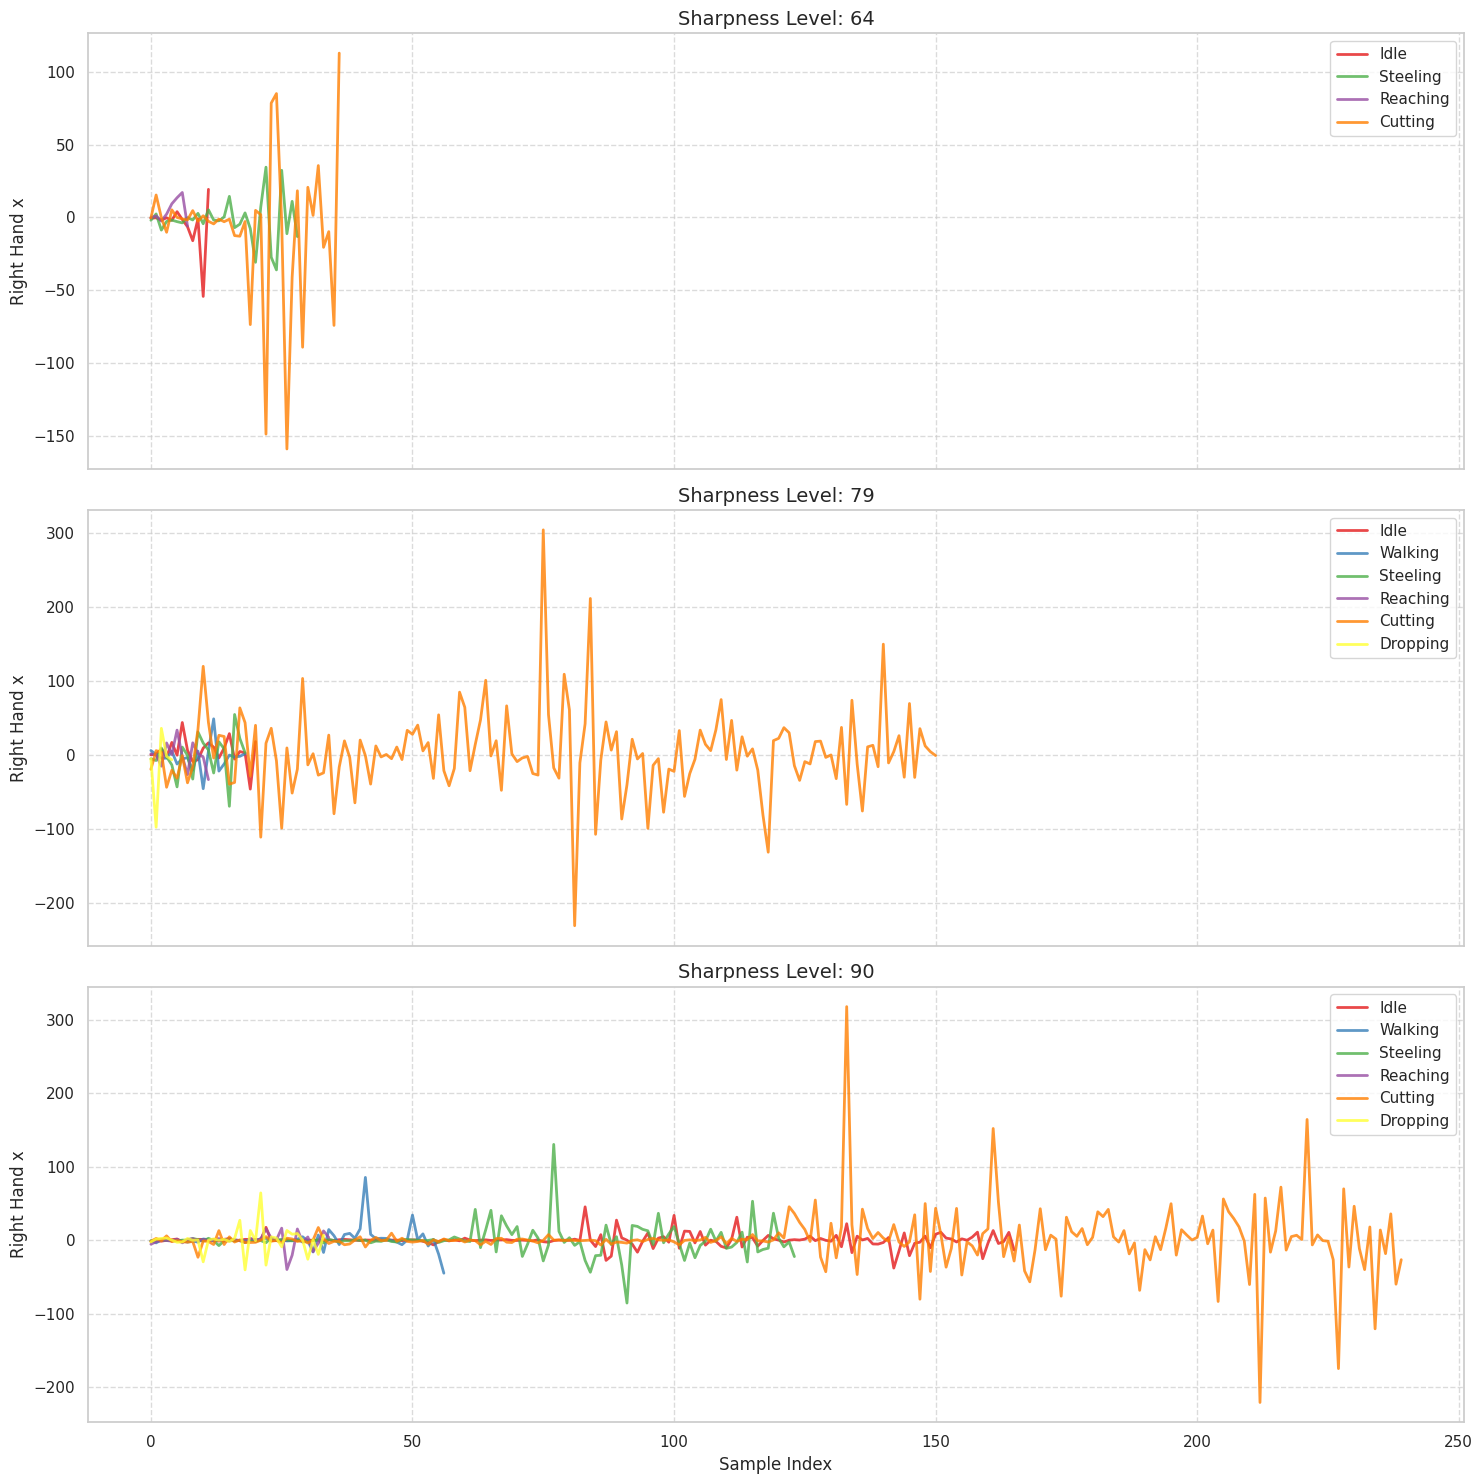

In [14]:
create_facet_plots(
    df,
    value_column='Right Hand x',
    downsample_factor=70
)

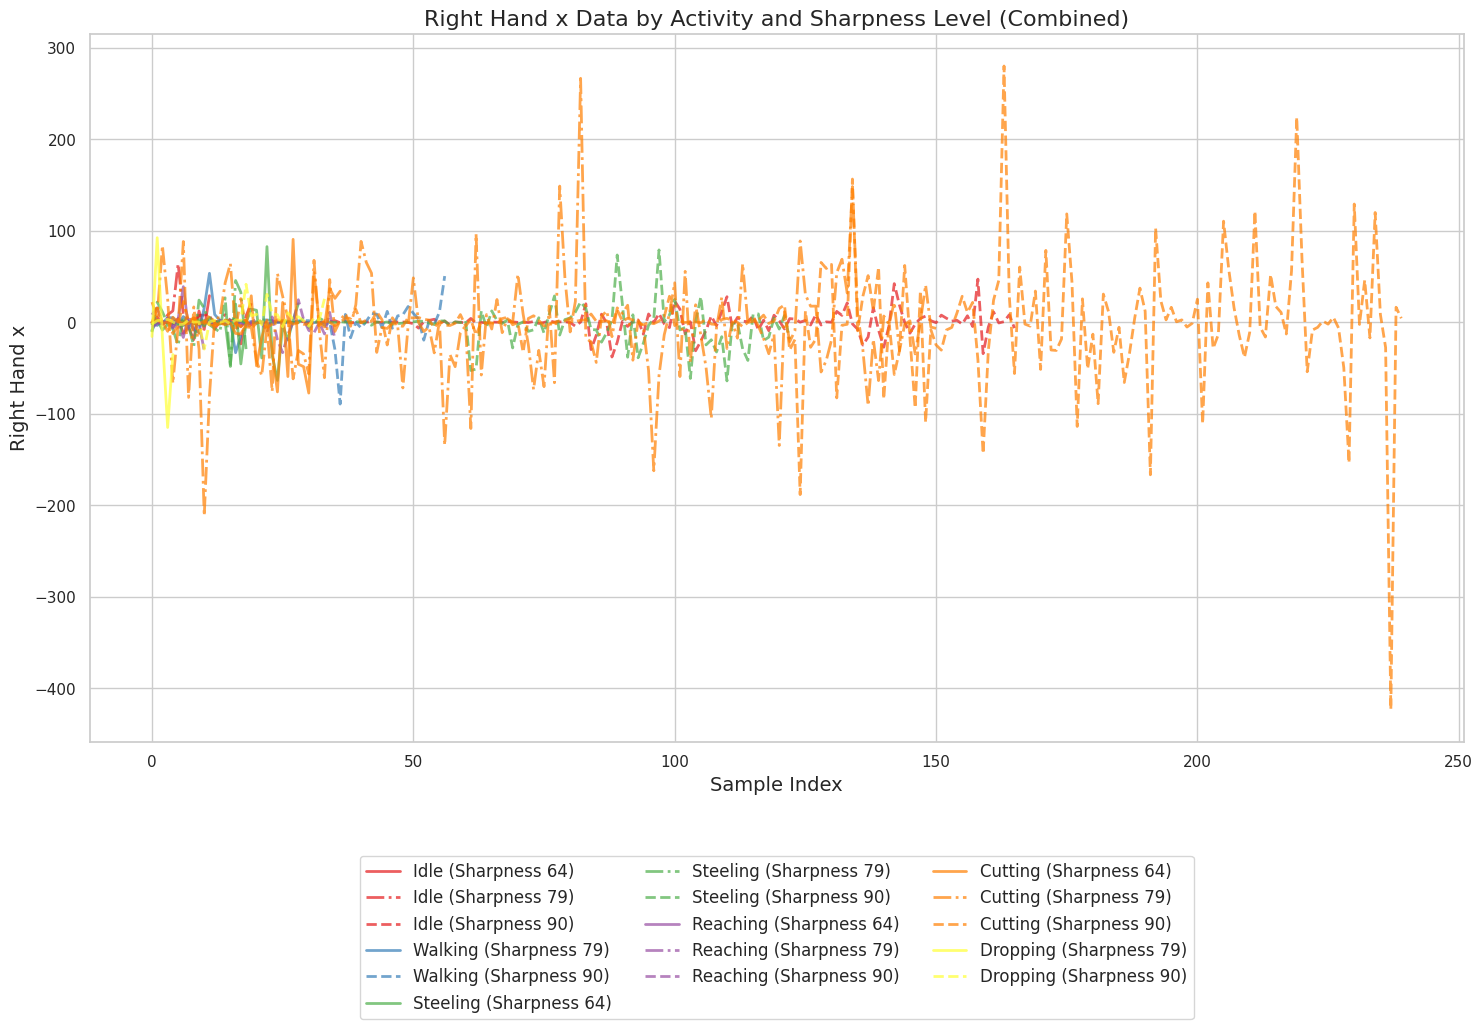

In [15]:
visualize_combined_sharpness(
    df,
    value_column='Right Hand x',
    downsample_factor=70
)

In [16]:
df.columns.tolist()

['Frame',
 'Label',
 'Pelvis x',
 'Pelvis y',
 'Pelvis z',
 'L5 x',
 'L5 y',
 'L5 z',
 'L3 x',
 'L3 y',
 'L3 z',
 'T12 x',
 'T12 y',
 'T12 z',
 'T8 x',
 'T8 y',
 'T8 z',
 'Neck x',
 'Neck y',
 'Neck z',
 'Head x',
 'Head y',
 'Head z',
 'Right Shoulder x',
 'Right Shoulder y',
 'Right Shoulder z',
 'Right Upper Arm x',
 'Right Upper Arm y',
 'Right Upper Arm z',
 'Right Forearm x',
 'Right Forearm y',
 'Right Forearm z',
 'Right Hand x',
 'Right Hand y',
 'Right Hand z',
 'Left Shoulder x',
 'Left Shoulder y',
 'Left Shoulder z',
 'Left Upper Arm x',
 'Left Upper Arm y',
 'Left Upper Arm z',
 'Left Forearm x',
 'Left Forearm y',
 'Left Forearm z',
 'Left Hand x',
 'Left Hand y',
 'Left Hand z',
 'Right Upper Leg x',
 'Right Upper Leg y',
 'Right Upper Leg z',
 'Right Lower Leg x',
 'Right Lower Leg y',
 'Right Lower Leg z',
 'Right Foot x',
 'Right Foot y',
 'Right Foot z',
 'Right Toe x',
 'Right Toe y',
 'Right Toe z',
 'Left Upper Leg x',
 'Left Upper Leg y',
 'Left Upper Leg z',
 '

# **DATA normalization**

In [17]:
import tensorflow as tf
from keras import layers

train_dataset = df.sample(frac=0.8, random_state=42)
test_dataset = df.drop(train_dataset.index)

numeric_cols = df.select_dtypes(include=['int', 'int64', 'float', 'float64']).columns.tolist()

train_features = train_dataset[numeric_cols].copy()
test_features = test_dataset[numeric_cols].copy()

train_labels = train_features.pop('sharpness')
test_labels = test_features.pop('sharpness')

2025-03-29 02:48:04.399572: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-29 02:48:04.406317: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743176884.411921   34651 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743176884.413579   34651 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743176884.418975   34651 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [18]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [19]:
normalizer.adapt(np.array(train_features))

I0000 00:00:1743176885.580845   34651 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5395 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9


# **Model Training and Feature Evaluation**

In [20]:
# First, let's convert the sharpness values to discrete classes
# assuming sharpness is already in train_labels and test_labels

# Get unique sharpness values
unique_sharpness = np.sort(np.unique(np.concatenate([train_labels, test_labels])))
print(f"Unique sharpness values: {unique_sharpness}")
print(f"Number of classes: {len(unique_sharpness)}")

# Create a mapping from sharpness values to class indices
sharpness_to_class = {value: idx for idx, value in enumerate(unique_sharpness)}
class_to_sharpness = {idx: value for idx, value in enumerate(unique_sharpness)}

# Convert to class indices
train_labels_class = np.array([sharpness_to_class[val] for val in train_labels])
test_labels_class = np.array([sharpness_to_class[val] for val in test_labels])

print(f"Train labels shape: {train_labels_class.shape}")
print(f"Test labels shape: {test_labels_class.shape}")

Unique sharpness values: [64 79 90]
Number of classes: 3
Train labels shape: (53883,)
Test labels shape: (13471,)


In [21]:
def build_model(norm_layer, input_shape, num_classes):
    model = tf.keras.Sequential([
        norm_layer,
        layers.Dense(64, activation='relu'),
        layers.Dropout(0,3),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0,3),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

    return model

In [22]:
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [23]:
num_classes = len(unique_sharpness)
input_shape = train_features.shape[1]
model = build_model(normalizer, input_shape, num_classes)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (53883, 71)            │           143 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 143 (576.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 143 (576.00 B)

In [24]:
%%time
history = model.fit(
    np.array(train_features),
    train_labels_class,
    validation_split=0.2,
    epochs=50,
    batch_size=16,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)]
)

Epoch 1/50


I0000 00:00:1743176886.114622   34748 service.cc:152] XLA service 0x788c54008210 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743176886.114636   34748 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2025-03-29 02:48:06.124920: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743176886.185737   34748 cuda_dnn.cc:529] Loaded cuDNN version 90300


 239/2695 ━━━━━━━━━━━━━━━━━━━━ 1s 637us/step - accuracy: 0.6660 - loss: 0.9272

I0000 00:00:1743176886.795976   34748 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2695/2695 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7092 - loss: 0.6648 - val_accuracy: 0.7543 - val_loss: 0.4924
Epoch 2/50
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 2s 788us/step - accuracy: 0.7643 - loss: 0.4730 - val_accuracy: 0.7683 - val_loss: 0.4577
Epoch 3/50
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 2s 802us/step - accuracy: 0.7782 - loss: 0.4428 - val_accuracy: 0.7856 - val_loss: 0.4389
Epoch 4/50
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 2s 782us/step - accuracy: 0.8035 - loss: 0.4072 - val_accuracy: 0.7946 - val_loss: 0.4255
Epoch 5/50
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 2s 779us/step - accuracy: 0.8171 - loss: 0.3820 - val_accuracy: 0.7981 - val_loss: 0.4183
Epoch 6/50
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 2s 778us/step - accuracy: 0.8315 - loss: 0.3594 - val_accuracy: 0.8084 - val_loss: 0.4022
Epoch 7/50
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 2s 808us/step - accuracy: 0.8384 - loss: 0.3484 - val_accuracy: 0.8218 - val_loss: 0.3974
Epoch 8/50
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 2s 793us/step - accuracy: 0.8419 - loss: 0.3395

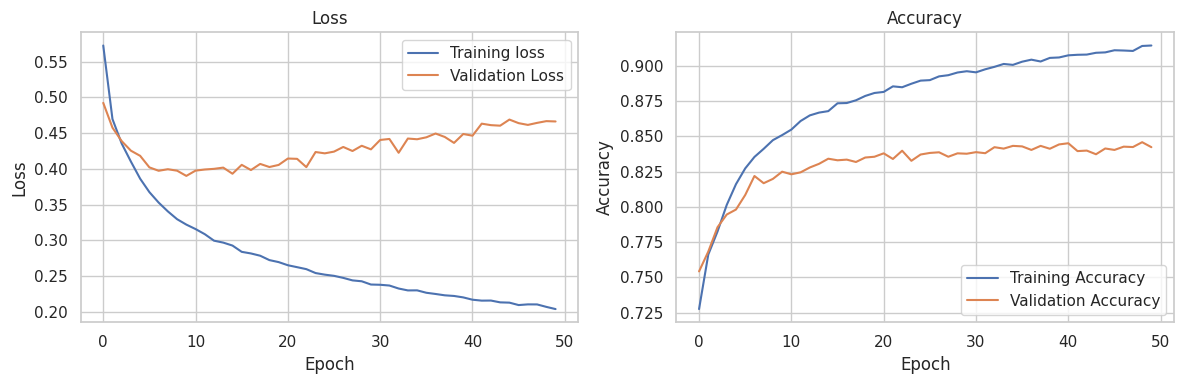

In [25]:
plot_history(history)

In [26]:
# Evaluate the model on test data
test_results = model.evaluate(np.array(test_features), test_labels_class, verbose=1)
print(f'Test Loss: {test_results[0]:.4f}')
print(f'Test Accuracy: {test_results[1]:.4f}')

421/421 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8787 - loss: 0.3500
Test Loss: 0.4484
Test Accuracy: 0.8431


421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step


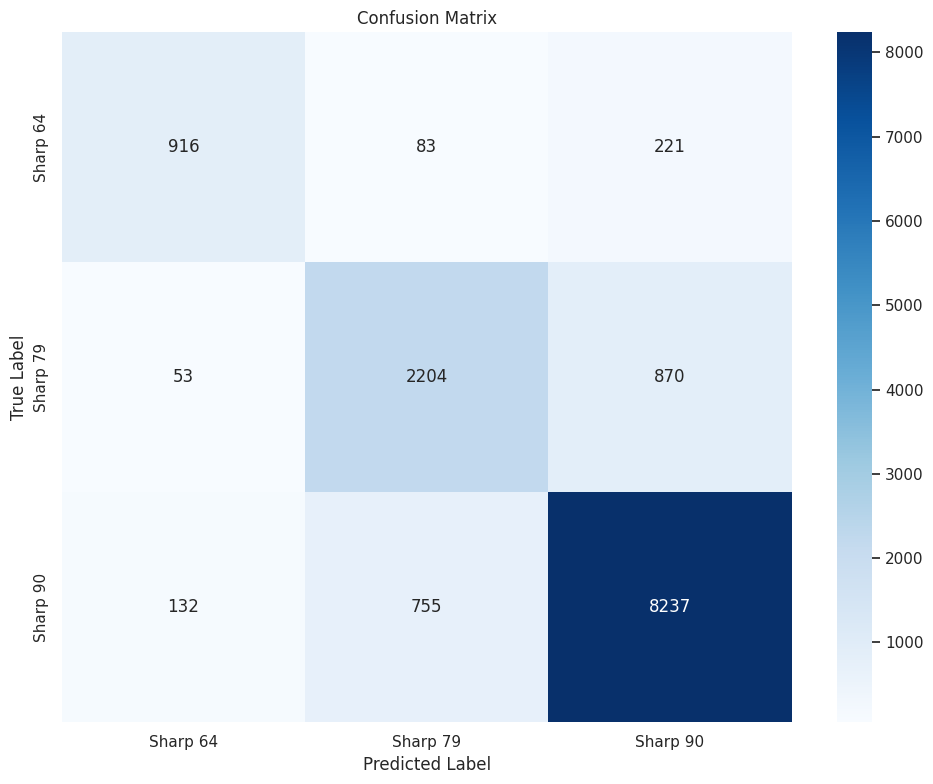

In [27]:
# Make predictions and create confusion matrix
predictions = model.predict(np.array(test_features))
predicted_classes = np.argmax(predictions, axis=1)

# Create confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

cm = confusion_matrix(test_labels_class, predicted_classes)

# Create class labels for the confusion matrix
if len(unique_sharpness) <= 10:  # If not too many classes, use actual values
    class_labels = [f'Sharp {val}' for val in unique_sharpness]
else:
    class_labels = [f'Class {i}' for i in range(len(unique_sharpness))]

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, 
            yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [28]:
# Print classification report
print("Classification Report:")
print(classification_report(test_labels_class, predicted_classes, 
                           target_names=class_labels))

Classification Report:
              precision    recall  f1-score   support

    Sharp 64       0.83      0.75      0.79      1220
    Sharp 79       0.72      0.70      0.71      3127
    Sharp 90       0.88      0.90      0.89      9124

    accuracy                           0.84     13471
   macro avg       0.81      0.79      0.80     13471
weighted avg       0.84      0.84      0.84     13471



421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step


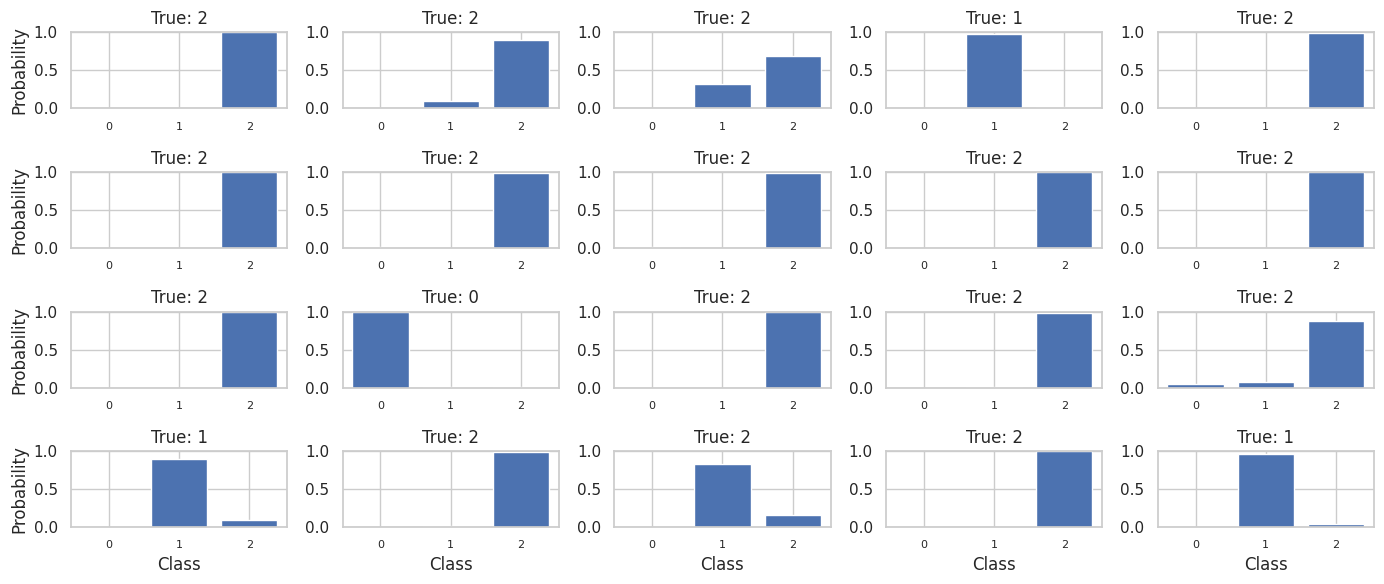

In [29]:
# Visualize the prediction confidence
# Get the predicted probabilities for each class
prediction_probs = model.predict(np.array(test_features))

# Plot prediction confidence for a sample of test instances
plt.figure(figsize=(14, 6))
sample_size = min(20, len(test_labels_class))  # Sample size (adjust as needed)
sample_indices = np.random.choice(len(test_labels_class), sample_size, replace=False)

# Create bar chart of prediction probabilities for each sample
for i, idx in enumerate(sample_indices):
    plt.subplot(4, 5, i+1)  # Adjust grid size based on sample size
    true_class = test_labels_class[idx]
    plt.bar(range(num_classes), prediction_probs[idx])
    plt.title(f'True: {true_class}')
    plt.xticks(range(num_classes), fontsize=8)
    plt.ylim(0, 1)
    if i % 5 == 0:  # Add y-label for leftmost plots
        plt.ylabel('Probability')
    if i >= 15:  # Add x-label for bottom plots
        plt.xlabel('Class')

plt.tight_layout()
plt.show()

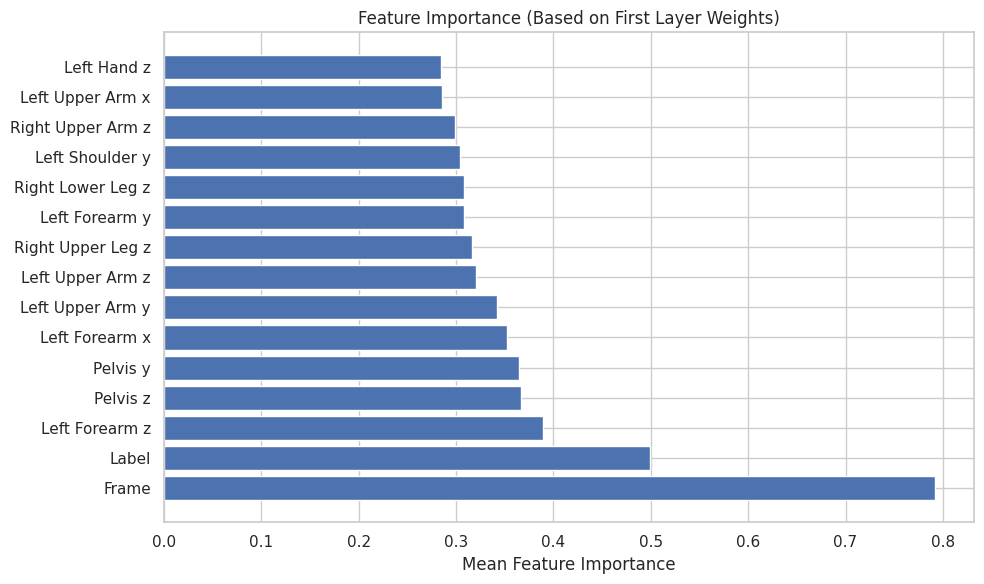

In [31]:
# Optionally: Create a feature importance analysis
def analyze_feature_importance(model, feature_names):
    # For a simple neural network, we can look at the weights of the first layer
    # Not as accurate as methods like SHAP, but gives a rough idea
    first_layer_weights = model.layers[1].get_weights()[0]  # Skip normalization layer
    
    # Calculate the absolute importance of each feature
    importance = np.mean(np.abs(first_layer_weights), axis=1)
    
    # Sort features by importance
    sorted_idx = np.argsort(importance)[::-1]
    sorted_importance = importance[sorted_idx]
    sorted_features = [feature_names[i] for i in sorted_idx]
    
    # Plot top features
    plt.figure(figsize=(10, 6))
    top_n = min(15, len(feature_names))  # Show top 15 features or all if fewer
    plt.barh(range(top_n), sorted_importance[:top_n], align='center')
    plt.yticks(range(top_n), sorted_features[:top_n])
    plt.xlabel('Mean Feature Importance')
    plt.title('Feature Importance (Based on First Layer Weights)')
    plt.tight_layout()
    plt.show()
    
    return sorted_features, sorted_importance

# Analyze feature importance
feature_names = train_features.columns.tolist()
important_features, importance_values = analyze_feature_importance(model, feature_names)